#### Нашей задачей будет построение логистической модели для задачи кредитного скоринга.
#### Данные представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	     ----Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                         ---- Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	----Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio ----	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	----Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate ----Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse----	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; ; тип -	integer
* NumberOfDependents ----Число человек в семье кредитозаёмщика; тип -	integer

In [1]:
%pylab inline
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

In [3]:
## Считываем данные
data = pd.read_csv('train_logistic_1.txt', sep =';')

In [4]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

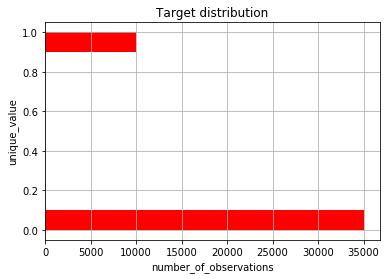

In [5]:
## Посмотрим на распределение классов в зависимой переменной

ax =data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [6]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names


['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [7]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table =delete_nan(data)


In [8]:
## Разделяем таргет и признаки 
X =table[independent_columns_names]
y = table['SeriousDlqin2yrs']


### Подбор параметров для модели логистической регрессии 

In [9]:
## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=2 для воспроизводимости результатов
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=2, class_weight= 'balanced')
lr

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=2,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [10]:
## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны, 
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
reg_C =[1, 10, 30, 50, 70, 90]
reg_C

[1, 10, 30, 50, 70, 90]

#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0  до 1.   Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [11]:
## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть 
## значения roc-auc на кросс-валидации из 3 фолдов. Используем модуль cross_val_score для подсчёта roc-auc
## Для стандартизации данных используем модуль preprocessing и функцию StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
scoring = []
Z = StandardScaler().fit_transform(X)
for i in reg_C:

    estimator = LogisticRegression(C=i, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=2,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
    
    score =cross_val_score(estimator, Z, y,  scoring = 'roc_auc', cv = 3)    
    scoring.append(score)
scoring = np.asmatrix(scoring)

In [12]:
## Матрица scoring содержит значения roc-auc на 3 фолдах для кадого значения параметра reg_С. Строка - это значения roc-auc 
## на 3 фолдах для определённого параметра reg_C . 
scoring

matrix([[ 0.78810967,  0.78799861,  0.78759238],
        [ 0.78828184,  0.78816089,  0.7877086 ],
        [ 0.78829714,  0.78817426,  0.78771708],
        [ 0.78830009,  0.78817595,  0.78771972],
        [ 0.78830039,  0.78817647,  0.78772028],
        [ 0.78830116,  0.78817708,  0.78772079]])

In [15]:
## Для выбора лучшего значения коэффициента C посмотрим на среднее значение roc-auc на кросс-валидации по трём фолдам
## Выберите лучший параметр C
print(max(scoring.mean(axis = 1)), 'C =90')



[[ 0.78806635]] C =90


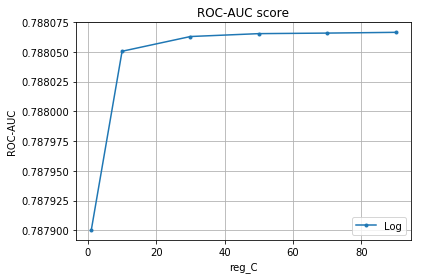

In [16]:
## Нарисуем график зависиомти среднего значения roc-auc от значения параметра C в логит.регрессии
pylab.plot(reg_C, scoring.mean(axis = 1), marker='.', label='Log')
pylab.grid(True)
pylab.xlabel('reg_C')
pylab.ylabel('ROC-AUC')
pylab.title('ROC-AUC score')
pylab.legend(loc='lower right')

## Кросс-валидация 

#### Для проверки на устойчивость логистической модели, используем метод кросс-валидации.  
#### Модель является устойчивой, если разность(дельта) между максимальным и минимальным значением ROC-AUC на кросс-валидации будет небольшая.

In [17]:
## Задаём настроенные параметры нашей  модели. 

lr = LogisticRegression(C=90, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=2,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [18]:
## Импортируем функцию StratifiedKFold для того, чтобы сделать стратифицированную кросс-валидацию
from sklearn.model_selection import StratifiedKFold
## В roc_auc_list будет храниться значения  roc-auc модели на тестовой выборке каждой из итерации кросс-валидации
from sklearn.metrics import roc_auc_score
roc_auc_list = []
## Количество фолдов возьмем равным 3.  random_state=2 для воспроизводимости.
skf = StratifiedKFold(n_splits=3,random_state=2)

## разбиваем выборку на три фолда, выделяя тренировочные и тестовые наборы в каждой из итерации.
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
## Стандартизируем X_train и X_test. 
    q= StandardScaler().fit(X_train)
    q_mean= q.mean_
    q_std =q.std_
    X_train = StandardScaler().fit_transform(X_train)
    X_test  = (X_test -q_mean)/q_std
     

## Строим модель на каждой тренировочной выборке
    lr.fit(X_train,y_train)
    pred = lr.predict_proba(X_test)[:,1]
## Высчитываем значение roc_auc на каждой тестовой выборке
    fold_roc_auc = roc_auc_score(y_test, pred)
## Записываем результат в roc_auc_list
    roc_auc_list.append(fold_roc_auc)

    
roc_auc_list    

/Users/valeria/Documents/condas/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function std_ is deprecated; Attribute ``std_`` will be removed in 0.19. Use ``scale_`` instead
  warnings.warn(msg, category=DeprecationWarning)
/Users/valeria/Documents/condas/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function std_ is deprecated; Attribute ``std_`` will be removed in 0.19. Use ``scale_`` instead
  warnings.warn(msg, category=DeprecationWarning)
/Users/valeria/Documents/condas/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function std_ is deprecated; Attribute ``std_`` will be removed in 0.19. Use ``scale_`` instead
  warnings.warn(msg, category=DeprecationWarning)


[0.78830139249049314, 0.78818051488938934, 0.78771182595429123]

##### Посчитайте  разность(дельта) и ответьте на вопрос, будет ли модель устойчива, если допустимую дельту взять за 0,05

In [19]:

print(max(roc_auc_list)  -min(roc_auc_list),'->' 'Stable model')

0.000589566536202 ->Stable model


## Обучение

In [20]:
## Используя ранее кросс-валидацию, мы подобрали параметры модели, посмотрели на устойчивость модели
## при этих параметрах. Давайте обучим модель на всем сете.

In [21]:
## Задаём настроенные параметры нашей  модели. 
lr = LogisticRegression(C=90, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=2,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [22]:
## Стандартизируем весь сет
Train = StandardScaler().fit_transform(X)

In [23]:
## Обучение
lr.fit(Train, y)

LogisticRegression(C=90, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=2,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [25]:
## Вычислим значения ROC-AUC метрики для  настроенной модели на всей выборке.
from sklearn.metrics import roc_auc_score
roc = roc_auc_score(y,lr.predict_proba(Train)[:,1] )
print(roc)

0.788329296081
